# Feature postprocessing from paper.
- Title:  "Predicting yeast synthetic lethal genetic interactions using protein domains"
- Authors: Bo Li, Feng Luo,School of Computing,Clemson University,Clemson, SC, USA
- e-mail: bol, luofeng@clemson.edu
- year:2009 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns
import matplotlib.cm as cm
import scipy as scipy
import random

### Importing datasets 

#### Link to the github repo where the datasets to be downloaded:
[DOWNLOAD THE DATASETS HERE](https://github.com/leilaicruz/machine-learning-for-yeast/tree/dev_Leila/datasets-for-learning)

In [2]:
import os
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path_SL = "datasets/data-synthetic-lethals.xlsx"
rel_path_nSL="datasets/data-positive-genetic.xlsx"
rel_path_domains="datasets/proteins-domains-from-Pfam.xlsx"

abs_file_path_SL = os.path.join(script_dir, rel_path_SL)
abs_file_path_nSL = os.path.join(script_dir, rel_path_nSL)
abs_file_path_domains = os.path.join(script_dir, rel_path_domains)

os.chdir('../') #<-- for binder os.chdir('../')
my_path_sl= abs_file_path_SL
my_path_non_sl=abs_file_path_nSL
my_path_domains=abs_file_path_domains

data_sl=pd.read_excel(my_path_sl,header=0)
data_domains=pd.read_excel(my_path_domains,header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_nonsl=pd.read_excel(my_path_non_sl,header=0)

## Building the feature matrix
One matrix for true SL where each row is one pair of SL. Every raw will be a vector of 0,1 or 2 depending on the comparison with the domain list. For row i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .

### Building the list of proteins domains id per protein pair separately :
- List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
- List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:
# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']



# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

population = np.arange(0,len(data_sl))

# For loop for 10000 pairs sampled randomly from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair

for m in random.sample(list(population), 100):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())

In [4]:
print('We are going to analyze',len((protein_a_list)) ,'protein pairs, out of',len(data_sl),'SL protein pairs')
print('We are going to analyze',len((protein_a_list_non)) ,'protein pairs, out of',len(data_nonsl),'positive protein pairs')

We are going to analyze 100 protein pairs, out of 17871 SL protein pairs
We are going to analyze 100 protein pairs, out of 43340 positive protein pairs


### Postprocessing #1:  Remove protein pairs from study if either protein in the pair does not contain any domain

In [5]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)
protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

In [6]:
print('The empty domain in the SL were:', len(protein_a_list)-len(protein_a_list_new), 'out of', len(protein_a_list),'domains')
print('The empty domain in the nSL were:', len(protein_a_list_non)-len(protein_a_list_non_new), 'out of', len(protein_a_list_non),'domains')

The empty domain in the SL were: 9 out of 100 domains
The empty domain in the nSL were: 3 out of 100 domains


### Feature engineering: Select from each ordered indexes of domain id list which of them appear once, in both or in any of the domains of each protein pair

#### Define function `get_indexes`

In [7]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,2,4,5,6,7,8,9,10]
get_indexes(2,a)

[1, 2]

In [8]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_new)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_new)):
        index_a=[]
        pair=[protein_a_list_new[i],protein_b_list_new[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    for i in np.arange(0,len(pair_a_b_array)):  
        array,index,counts=np.unique(pair_a_b_array[i],return_index=True,return_counts=True)
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),i]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),i]=1
            # print(index_a[m],i)
    return protein_feat_true

In [9]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)
protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)

### How many ones and twos are in each dataset

In [10]:
index_2_true=protein_feat_true_pd.where(protein_feat_true_pd==2)
index_2_true_count=index_2_true.count(axis=1).sum()

index_1_true=protein_feat_true_pd.where(protein_feat_true_pd==1)
index_1_true_count=index_1_true.count(axis=1).sum()

index_2_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==2)
index_2_nontrue_count=index_2_nontrue.count(axis=1).sum()

index_1_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==1)
index_1_nontrue_count=index_1_nontrue.count(axis=1).sum()


print('fraction of twos in the SL array is',index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of ones in the SL array is',index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of twos in the PI array is',index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))
print('fraction of ones in the PI array is',index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))

fraction of twos in the SL array is 7.265461810916357e-05
fraction of ones in the SL array is 0.0008464263009717555
fraction of twos in the PI array is 4.4304336712959016e-05
fraction of ones in the PI array is 0.0008179262162392434


#### Bar plot to visualize these numbers 

([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

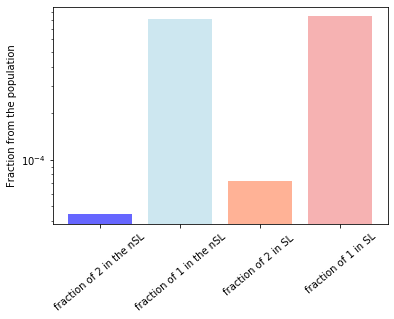

In [11]:
plt.bar(['fraction of 2 in the nSL','fraction of 1 in the nSL'],[index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)),index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns))],alpha=0.6,color=['blue','lightblue']), 

plt.bar(['fraction of 2 in SL ','fraction of 1 in SL'],[index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)),index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns))],alpha=0.6,color=['coral','lightcoral'])

plt.ylabel('Fraction from the population')
plt.yscale('log')
plt.xticks(rotation=40)

#### Adding the labels(response variables) to each dataset

In [12]:
protein_feat_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))
protein_feat_non_true_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))

#### Joining both datasets

In [13]:
feature_post=pd.concat([protein_feat_true_pd,protein_feat_non_true_pd],axis=0)
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))
print('The number of features are:',feature_post.shape[1])
print('The number of samples are:',feature_post.shape[0])

The number of features are: 3026
The number of samples are: 188


### Postprocessing and exploration of the feature matrix of both datasets

In [14]:
mean=feature_post.T.describe().loc['mean']
std=feature_post.T.describe().loc['std']
lethality=feature_post['lethality']

corr_keys=pd.concat([mean,std,lethality],axis=1)

### Viz of the stats 

Text(0.5, 1.08, 'Pairplot to see data dependencies with Lethality')

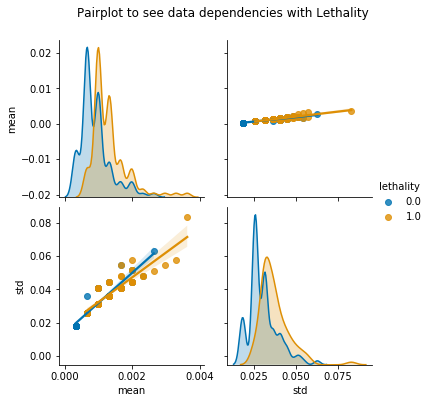

In [15]:
pair=sns.pairplot(corr_keys,hue='lethality',diag_kind='kde',kind='reg',palette='colorblind')
pair.fig.suptitle('Pairplot to see data dependencies with Lethality',y=1.08)

In [16]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_sl=protein_feat_true_pd.drop(columns=['lethality'])
x_nsl=protein_feat_non_true_pd.drop(columns=['lethality'])

X_sl_scaled = scaler.fit_transform(x_sl.T)
X_nsl_scaled = scaler.fit_transform(x_nsl.T)


In [207]:
def PCA_component_contribution(scaled_matrix,original_data):
    from sklearn.decomposition import PCA

    model = PCA(0.95).fit(scaled_matrix)
    ## apply dimensionality reduction to X_train
    output_pca = model.transform(scaled_matrix)
    
    total=sum(model.explained_variance_)


    main_features=[]
    max_contribution=np.max(model.explained_variance_/total)
    for k in np.arange(0,model.components_.shape[0]):
        if max_contribution/2<model.explained_variance_[k]/total < max_contribution:
            main_features.append(k)

    # number of components
    n_pcs= model.components_.shape[0] # the amount of components of the PCA,main protein domains

    # get the index of the most important feature on EACH component
    # LIST COMPREHENSION HERE
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = original_data.columns
    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    # names of maximum contributors 
    max_contributors_names = data_domains['domain-name'][main_features] + data_domains['domain-descrip'][main_features]

    # LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    df = pd.DataFrame(dic.items(),columns=['pca-component','domain-number'])

    return df,main_features,model.components_

In [208]:
df_sl,max_contributors_nsl,components_pca_nsl=PCA_component_contribution(X_nsl_scaled,x_nsl)
df_nsl,max_contributors_sl,components_pca_sl=PCA_component_contribution(X_sl_scaled,x_sl)

In [220]:
df_shared_domains=pd.merge(df_sl,df_nsl,how='inner',on='domain-number')
domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_shared_domains['domain-description']=domains_description[df_shared_domains['domain-number']]
df_shared_domains


,pca-component_x,domain-number,pca-component_y,domain-description
0,PC0,36,PC44,AA_permease_2; Amino acid/polyamine transporter I
1,PC1,2,PC20,2-Hacid_dh; D-isomer specific 2-hydroxyacid de...
2,PC2,35,PC31,AA_permease; Amino acid permease/ SLC12A domain
3,PC3,68,PC3,AIRC; PurE domain
4,PC4,4,PC8,2-oxoacid_dh; 2-oxoacid dehydrogenase acyltran...
...,...,...,...,...
58,PC70,82,PC52,ANAPC10; APC10/DOC domain
59,PC71,40,PC53,"ABC_membrane_2; ABC transporter type 1, transm..."
60,PC76,60,PC30,AFT; Iron-regulated transcriptional activator AFT
61,PC78,20,PC63,AAA_22; AAA+ ATPase domain


In [217]:
df_sl_exclusive=pd.merge(df_sl,df_nsl,how='left',on='domain-number')

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_sl_exclusive['domain-description']=domains_description[df_sl_exclusive['domain-number']]
df_sl_exclusive[pd.isnull(df_sl_exclusive['pca-component_y'])]

,pca-component_x,domain-number,pca-component_y,domain-description
5,PC5,15,NaN,"AAA; ATPase, AAA-type, core"
8,PC8,0,NaN,"1-cysPrx_C; Peroxiredoxin, C-terminal"
15,PC14,54,NaN,ADH_zinc_N_2
16,PC15,6,NaN,2OG-FeII_Oxy_4
22,PC20,33,NaN,AATase; Alcohol acetyltransferase/N-acetyltran...
28,PC26,19,NaN,AAA_19
32,PC30,52,NaN,"ADH_N; Alcohol dehydrogenase, N-terminal"
40,PC37,92,NaN,ANTH; AP180 N-terminal homology (ANTH) domain
43,PC40,42,NaN,ABC_tran_Xtn; ABC-transporter extension domain
48,PC44,91,NaN,"ANAPC_CDC26; Anaphase-promoting complex, subun..."


In [218]:
df_nsl_exclusive=pd.merge(df_sl,df_nsl,how='right',on='domain-number')

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_nsl_exclusive['domain-description']=domains_description[df_nsl_exclusive['domain-number']]
df_nsl_exclusive[pd.isnull(df_nsl_exclusive['pca-component_x'])]

,pca-component_x,domain-number,pca-component_y,domain-description
63,NaN,45,PC0,"ACBP; Acyl-CoA-binding protein, ACBP"
64,NaN,81,PC10,"AMP_N; Aminopeptidase P, N-terminal"
65,NaN,57,PC14,ADSL_C; Adenylosuccinate lyase C-terminal
66,NaN,38,PC18,ABC2_membrane; ABC-2 type transporter
67,NaN,25,PC29,AAA_6
68,NaN,41,PC37,ABC_tran; ABC transporter-like
69,NaN,12,PC41,60KD_IMP; Membrane insertase OXA1/ALB3/YidC
70,NaN,61,PC47,AGA2
71,NaN,79,PC48,"AMPK1_CBM; AMP-activated protein kinase, glyco..."
72,NaN,70,PC55,"AIRS_C; AIR synthase-related protein, C-termin..."


## Let see to features that get repeated after finding the Principal components  to describe the data 

In [175]:
duplicated_features_sl=df_sl[df_sl.iloc[:,1].duplicated()]
repeated_features_sl=pd.DataFrame()

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

repeated_features_sl['domain-name']=domains_name[duplicated_features_sl.iloc[:,1]] 
repeated_features_sl['domain-description']=domains_description[duplicated_features_sl.iloc[:,1]]

duplicated_features_nsl=df_nsl[df_nsl.iloc[:,1].duplicated()]
repeated_features_nsl=pd.DataFrame()

repeated_features_nsl['domain-name']=domains_name[duplicated_features_nsl.iloc[:,1]] 
repeated_features_nsl['domain-description']=domains_description[duplicated_features_nsl.iloc[:,1]]

In [177]:
repeated_features_nsl

,domain-name,domain-description
0,PF00080,AATF-Che1; AATF leucine zipper-containing domain
1,PF00011,2-oxogl_dehyd_N; 2-oxoglutarate dehydrogenase ...
2,PF00022,"40S_S4_C; 40S ribosomal protein S4, C-terminal..."
3,PF00076,"AAR2; A1 cistron-splicing factor, AAR2"
4,PF00132,"AFG1_ATPase; ATPase, AFG1-like"
5,PF00186,"ANAPC9; Anaphase-promoting complex, subunit 9"


In [178]:
only_sl_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='left',on=['domain-name'])
data_only_sl = only_sl_pd[pd.isnull(only_sl_pd['domain-description_y'])]
data_only_sl

,domain-name,domain-description_x,domain-description_y
0,PF00136,AHSA1; Activator of Hsp90 ATPase homologue 1-like,NaN
1,PF00097,"ABC_membrane; ABC transporter type 1, transmem...",NaN
2,PF00025,5-FTHF_cyc-lig; 5-formyltetrahydrofolate cyclo...,NaN
3,PF00177,"ANAPC2; Anaphase-promoting complex subunit 2, ...",NaN
4,PF00032,"6PGD; 6-phosphogluconate dehydrogenase, C-term...",NaN
5,PF00081,AATase; Alcohol acetyltransferase/N-acetyltran...,NaN
7,PF00121,ADH_zinc_N_2,NaN
8,PF00111,"ACC_central; Acetyl-CoA carboxylase, central d...",NaN
9,PF00198,APG12; Ubiquitin-like protein Atg12,NaN


In [179]:
only_nsl_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='right',on=['domain-name'])
data_only_nsl = only_nsl_pd[pd.isnull(only_nsl_pd['domain-description_x'])]
data_only_nsl

,domain-name,domain-description_x,domain-description_y
1,PF00080,NaN,AATF-Che1; AATF leucine zipper-containing domain
2,PF00011,NaN,2-oxogl_dehyd_N; 2-oxoglutarate dehydrogenase ...
3,PF00076,NaN,"AAR2; A1 cistron-splicing factor, AAR2"
4,PF00132,NaN,"AFG1_ATPase; ATPase, AFG1-like"
5,PF00186,NaN,"ANAPC9; Anaphase-promoting complex, subunit 9"


In [180]:
shared_domains_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='inner',on=['domain-name'])
shared_domains_pd



,domain-name,domain-description_x,domain-description_y
0,PF00022,"40S_S4_C; 40S ribosomal protein S4, C-terminal...","40S_S4_C; 40S ribosomal protein S4, C-terminal..."


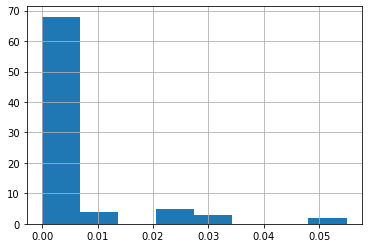

In [195]:
a_sl=x_sl.iloc[:,np.sort(df_sl.iloc[:,1])]
a_sl.describe().loc['mean'].hist(bins=8)

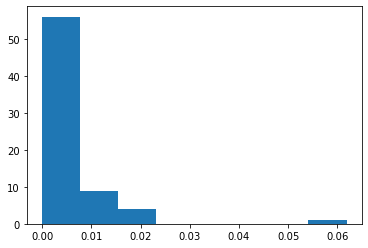

In [196]:
a_nsl=x_nsl.iloc[:,np.sort(df_nsl.iloc[:,1])]
plt.hist(a_nsl.describe().loc['mean'],bins=8);